# Пайплайн для выделения лучших кропов по текстовому запросу ViLD -> Clip -> Annoy

Все расчеты ниже получены по valid выборке датасета LVIS

* Применяем модель ViLD MaskRCNN к датасету, получаем кропы для картинок
* Применяем модель clip к каждому кропу, получаем эмбеддинги кропов
* Применяем модель clip к описанию категорий датасета LVIS, получаем эмбеддинги категорий
* Строим индекс annoy по эмбеддингам кропов для поиска ближайших соседей из кропов к каждой категории датасета
* Проводим анализ метрик

In [1]:
import tensorflow.compat.v1 as tf

tf.__version__

2022-05-10 13:28:49.089433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-10 13:28:49.089483: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.8.0'

In [2]:
from assh_utils import get_iou, load_json, nms

In [3]:
import os

root = "/home/asciishell/s3/asciishell-fsod/LVIS/"
js = load_json("/home/asciishell/s3/asciishell-fsod/LVIS/lvis_v1_val.json.zip")
images = [root + x["coco_url"].replace("http://images.cocodataset.org/", "") for x in js["images"]]
assert all([os.path.exists(x) for x in images[:100]])

In [4]:
import itertools
import math
import os
import pickle

import clip
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import torch
from annoy import AnnoyIndex
from sklearn.cluster import KMeans
from sklearn.metrics import average_precision_score
from tqdm.cli import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


## Применяем модель ViLD MaskRCNN с NMS
Сохраняем датафрейм с картинками и соответствующими кропами.

In [6]:
saved_model_dir = "/home/jupyter/mnt/s3/asciishell-fsod/image_path_v2"
session = tf.Session(graph=tf.Graph())
_ = tf.saved_model.loader.load(session, ["serve"], saved_model_dir)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /home/jupyter/mnt/s3/asciishell-fsod/image_path_v2/variables/variables


/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: session
  warnings.warn(message)


In [7]:
from collections import defaultdict

nms_threshold = 0.6
min_rpn_score_thresh = 0.9
min_box_area = 220
max_boxes_to_draw = 30

results = defaultdict(list)
for name in tqdm(images):
    roi_boxes, roi_scores, detection_boxes, image_info = session.run(
        ["RoiBoxes:0", "RoiScores:0", "2ndStageBoxes:0", "ImageInfo:0"],
        feed_dict={
            "Placeholder:0": [
                name,
            ]
        },
    )

    roi_boxes = np.squeeze(roi_boxes, axis=0)  # squeeze
    roi_scores = np.squeeze(roi_scores, axis=0)
    detection_boxes = np.squeeze(detection_boxes, axis=(0, 2))
    image_info = np.squeeze(image_info, axis=0)  # obtain image info
    image_scale = np.tile(image_info[2:3, :], (1, 2))

    rescaled_detection_boxes = detection_boxes / image_scale  # rescale
    # Apply non-maximum suppression to detected boxes with nms threshold.
    nmsed_indices = nms(detection_boxes, roi_scores, thresh=nms_threshold)

    # Compute RPN box size.
    box_sizes = (rescaled_detection_boxes[:, 2] - rescaled_detection_boxes[:, 0]) * (
        rescaled_detection_boxes[:, 3] - rescaled_detection_boxes[:, 1]
    )

    # Filter out invalid rois (nmsed rois)
    valid_indices = np.where(
        np.logical_and(
            np.isin(np.arange(len(roi_scores), dtype=np.int), nmsed_indices),
            np.logical_and(
                np.logical_not(np.all(roi_boxes == 0.0, axis=-1)),
                np.logical_and(roi_scores >= min_rpn_score_thresh, box_sizes > min_box_area),
            ),
        )
    )[0]

    detection_roi_scores = roi_scores[valid_indices][:max_boxes_to_draw, ...]
    rescaled_detection_boxes = rescaled_detection_boxes[valid_indices][:max_boxes_to_draw, ...]
    ymin, xmin, ymax, xmax = np.split(rescaled_detection_boxes, 4, axis=-1)

    results["image"].extend([name] * len(xmin))
    results["xmin"].extend(xmin.reshape(1, -1)[0])
    results["ymin"].extend(ymin.reshape(1, -1)[0])
    results["xmax"].extend(xmax.reshape(1, -1)[0])
    results["ymax"].extend(ymax.reshape(1, -1)[0])
    results["roi_scores"].extend(detection_roi_scores)

results = pd.DataFrame(results)
results.to_pickle(f"/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.pkl.zip")

100%|██████████| 19809/19809 [1:14:22<00:00,  4.44it/s]
/kernel/lib/python3.8/site-packages/ml_kernel/kernel.py:872: UserWarning: The following variables cannot be serialized: session
  warnings.warn(message)


In [8]:
results.head()

,image,xmin,ymin,xmax,ymax,roi_scores
0,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,293.381561,81.120750,331.104492,131.361664,0.999746
1,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,208.240906,26.461271,238.645737,84.545235,0.999742
2,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,317.082184,115.037201,365.056030,151.289627,0.999477
3,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,321.055481,46.822239,337.211456,77.540009,0.999447
4,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,337.668274,46.672073,356.634399,79.231155,0.999442


Округляем границы bbox. Удаяем слишком маленькие кропы и дубликаты. Сохраняем отсортированный и сокращенный датафрейм с картинками и кропами.

In [10]:
dfs = pd.read_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.pkl.zip")
dfs[["xmin", "ymin", "xmax", "ymax"]] = dfs[["xmin", "ymin", "xmax", "ymax"]].round().astype(np.int32).values
dfs = dfs[((dfs["xmin"] - dfs["xmax"]).abs() > 5) & ((dfs["ymin"] - dfs["ymax"]).abs() > 5)]
dfs = (
    dfs.sort_values(["image"])
    .drop_duplicates(["xmin", "ymin", "xmax", "ymax", "image"], keep="first")
    .sort_values(["image", "roi_scores", "xmin", "ymin", "xmax", "ymax"])
    .reset_index(drop=True)
)
dfs.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.sorted.pkl.zip")
dfs

,image,xmin,ymin,xmax,ymax,roi_scores
0,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,144,126,181,174,0.976964
1,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,155,92,197,156,0.977112
2,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,154,90,240,210,0.984891
3,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,220,209,258,242,0.987218
4,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/trai...,200,191,239,224,0.990206
...,...,...,...,...,...,...
422958,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,605,127,639,215,0.999944
422959,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,477,151,560,224,0.999953
422960,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,74,158,175,212,0.999956
422961,/home/jupyter/mnt/s3/asciishell-fsod/LVIS/val2...,61,215,127,342,0.999965


## Применяем модель clip к каждому кропу

Сохраняем полученные эмбеддинги для каждого кропа и датафрейм с картинками и кропами в соответствующем порядке.

In [11]:
clip_model, clip_preprocess = clip.load("/home/jupyter/mnt/s3/asciishell-fsod/models/ViT-B-32.pt", device)

In [12]:
embeddings = []
images = []
for index, row in tqdm(dfs.groupby("image")):
    img = PIL.Image.open(index)
    for _, row2 in row.iterrows():
        img_crop = img.crop(box=row2[["xmin", "ymin", "xmax", "ymax"]].values)
        image_input = clip_preprocess(img_crop).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image_input)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        embeddings.append(image_features[0].cpu().numpy())
        images.append(row2.to_dict())
embeddings = np.stack(embeddings)
images = pd.DataFrame(images)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid_emb.npy", embeddings)
images.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunMaskRCNN/valid.done.pkl.zip")

100%|██████████| 19803/19803 [1:55:26<00:00,  2.86it/s]


In [6]:
embeddings = np.load("/home/asciishell/s3/asciishell-fsod/RunMaskRCNN/valid_emb.npy")
images = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunMaskRCNN/valid.done.pkl.zip")

In [7]:
embeddings.shape

(422963, 512)

## Получим эмбеддинг для определения каждой категории датасета LVIS
Сохраним категорию и соответствующий ей эмбеддинг.

In [8]:
def get_vector_text(x):
    text_inputs = torch.cat([clip.tokenize(x)]).to(device)
    with torch.no_grad():
        text_features = clip_model.encode_text(text_inputs)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    return text_features[0].cpu().numpy()


def get_vector_image(x):
    img = PIL.Image.open(x)
    img.thumbnail((640, 640), PIL.Image.ANTIALIAS)
    img.show()
    image_input = clip_preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    return image_features[0].cpu().numpy()

In [8]:
categories_emb = []
categories = []
for category in tqdm(js["categories"]):
    categories_emb.append(get_vector_text(category["def"]))
    categories.append(category)
categories_emb = np.stack(categories_emb)
categories = pd.DataFrame(categories)
np.save("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories_emb.npy", categories_emb)
categories.to_pickle("/home/jupyter/mnt/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

In [10]:
categories_emb = np.load("/home/asciishell/s3/asciishell-fsod/RunYolo/categories_emb.npy")
categories = pd.read_pickle("/home/asciishell/s3/asciishell-fsod/RunYolo/categories.pkl.zip")

## Для эмбеддинга каждой категории найдем n ближайших соседей из эмбеддингов кропов

In [11]:
def cos_sim_matrix(a, b):
    return np.dot(a, b) / np.linalg.norm(b)

def get_ns_by_vector(vec, n):
    vec = vec.astype(np.float32)
    dist = cos_sim_matrix(embeddings, vec)
    idx = np.argsort(dist)
    top_idx = idx[: -n - 1 : -1]
    return top_idx, dist

## Проводим анализ метрик
Определим, относятся ли в действительности выделенные кропы к заданной категории (с помощью iou) и вычислим метрики качества.

In [13]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [14]:
metrics = []
annotation = pd.DataFrame(js['annotations'])
for index, category in tqdm(categories.iterrows(), total=categories.shape[0]):
    best = get_ns_by_vector(categories_emb[index], 30) # сколько есть максимально объектов каждой категории:
    x_conf = images.loc[best[0], 'roi_scores']
    tp = []
    x_iou = []
    for x in best[0]: # имеет ли смысл убрать кропы с одной картинки с большим iou?
        img = images.loc[x]
        for ann in annotation[annotation['image_id'] == int(img['image'][-16:-4])].iterrows():
            ann = ann[1]
            iou = get_iou({'x1': img['xmin'], 'x2': img['xmax'], 'y1': img['ymin'], 'y2': img['ymax']}, 
                    {'x1': ann['bbox'][0], 'x2': ann['bbox'][0] + ann['bbox'][2], 'y1': ann['bbox'][1], 'y2': ann['bbox'][1] + ann['bbox'][3]})
            if iou > 0.5 and ann['category_id'] == category['id']: # стоит ли рассматривать разные iou?
                x_iou.append(iou)
                tp.append(1)
                break
        else:
            x_iou.append(None)
            tp.append(0)
            
    for n_neighb in [1, 5, 10, 20, 30]: 
        metrics.append({
                        'category_id': category['id'], 
                        'category_name': category['name'],
                        'n_neighb': n_neighb,
                        'average_precision_conf': average_precision_score(tp[:n_neighb], x_conf[:n_neighb]),
                        'average_precision_dist': average_precision_score(tp[:n_neighb], 1 / np.array(best[1][:n_neighb])),
                        'average_precision_multi': average_precision_score(tp[:n_neighb], np.array(x_conf[:n_neighb]) / np.array(best[1][:n_neighb])),
                        'tp': np.sum(tp[:n_neighb]),
                        'dist_mean': np.mean(best[1][:n_neighb]), 
                        'conf_mean': np.mean(x_conf[:n_neighb]), 
                        'iou_mean': np.mean([x for x in x_iou[:n_neighb] if x is not None], dtype=np.float64), 
                       })
    
metrics = pd.DataFrame(metrics)
metrics.to_pickle('/home/asciishell/s3/asciishell-fsod/RunMaskRCNN/valid_metrics_bf.pkl.zip')

In [16]:
metrics["accuracy"] = metrics["tp"] / metrics["n_neighb"]

In [17]:
metrics.head()

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
0,1,aerosol_can,1,NaN,NaN,NaN,0,0.199188,0.946334,NaN,0.0
1,1,aerosol_can,5,NaN,NaN,NaN,0,0.204090,0.987943,NaN,0.0
2,1,aerosol_can,10,NaN,NaN,NaN,0,0.203175,0.990053,NaN,0.0
3,1,aerosol_can,20,NaN,NaN,NaN,0,0.200892,0.994065,NaN,0.0
4,1,aerosol_can,30,NaN,NaN,NaN,0,0.197133,0.992921,NaN,0.0


In [18]:
# в топе по accuracy простые и понятные категории (животные, популярные предметы)
metrics_ = metrics[metrics["n_neighb"] == 10]
metrics_.sort_values("accuracy", ascending=False).head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
1487,298,cone,10,1.000000,1.000000,1.000000,10,0.214791,0.999611,0.917521,1.0
2107,422,elephant,10,1.000000,1.000000,1.000000,10,0.208249,0.999413,0.937264,1.0
6007,1202,zebra,10,1.000000,1.000000,1.000000,10,0.199376,0.999660,0.964730,1.0
2222,445,fireplug,10,1.000000,1.000000,1.000000,10,0.183612,0.999598,0.949236,1.0
587,118,boat,10,1.000000,0.946781,0.976543,9,0.185198,0.997506,0.840481,0.9
4712,943,sheep,10,0.928263,1.000000,1.000000,9,0.216698,0.999613,0.945278,0.9
2842,569,horse,10,0.988889,0.988889,0.976543,9,0.215610,0.996077,0.894372,0.9
2477,496,giraffe,10,0.841226,0.906041,0.906041,9,0.219527,0.999185,0.961456,0.9
177,36,suitcase,10,0.988889,0.976543,0.976543,9,0.195928,0.997499,0.862775,0.9
397,80,cow,10,1.000000,0.946781,0.988889,9,0.225211,0.995093,0.961770,0.9


In [19]:
# не угадываем редкие объекты
metrics_.sort_values("accuracy").head(10)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
2,1,aerosol_can,10,NaN,NaN,NaN,0,0.203175,0.990053,NaN,0.0
3657,732,olive_oil,10,NaN,NaN,NaN,0,0.205074,0.996163,NaN,0.0
3662,733,omelet,10,NaN,NaN,NaN,0,0.231064,0.987230,NaN,0.0
3687,738,ottoman,10,NaN,NaN,NaN,0,0.215773,0.997297,NaN,0.0
3697,740,overalls_(clothing),10,NaN,NaN,NaN,0,0.201119,0.995033,NaN,0.0
3702,741,owl,10,NaN,NaN,NaN,0,0.216068,0.998975,NaN,0.0
3707,742,packet,10,NaN,NaN,NaN,0,0.227548,0.996087,NaN,0.0
3712,743,inkpad,10,NaN,NaN,NaN,0,0.237336,0.985307,NaN,0.0
3717,744,pad,10,NaN,NaN,NaN,0,0.212645,0.981988,NaN,0.0
3722,745,paddle,10,NaN,NaN,NaN,0,0.218679,0.979433,NaN,0.0


In [20]:
# 1203 * 6 - всего экспериментов
metrics.shape[0]

6015

In [21]:
# у нас много редких категорий и для них неправильно смотреть большое кол-во ближайших соседей
ann = annotation["category_id"].value_counts()
ann

45     9156
127    7022
217    3762
12     3116
827    2724
       ... 
532       1
251       1
619       1
803       1
238       1
Name: category_id, Length: 1035, dtype: int64

In [22]:
# проведем анализ для меньшего числа категорий
len(ann[ann > 100])

327

In [23]:
# общее количество экспериментов
metrics[metrics["category_id"].isin(ann[ann > 100].index)].shape[0]

1635

In [24]:
# общее количество экспериментов с ненулевым tp
q = metrics[(metrics["tp"] != 0) & metrics["category_id"].isin(ann[ann > 100].index)].shape[0]
q, q / 1635

(829, 0.5070336391437309)

In [25]:
# число категорий по которым нет верных ответов
q = metrics[
    (metrics["tp"] == 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
].shape[0]
q, q / 327

(146, 0.44648318042813456)

In [26]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.211009
5     0.932722
10    1.813456
20    3.366972
30    4.853211
Name: tp, dtype: float64

In [27]:
# среднее количество верных ответов для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["tp"].mean()

n_neighb
1     0.050000
5     0.311111
10    0.594444
20    1.072222
30    1.433333
Name: tp, dtype: float64

In [28]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.211009
5     0.322889
10    0.319490
20    0.290491
30    0.270818
Name: average_precision_conf, dtype: float64

In [29]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.211009
5     0.264127
10    0.258793
20    0.221139
30    0.208276
Name: average_precision_dist, dtype: float64

In [30]:
metrics[metrics["category_id"].isin(ann[ann > 100].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.211009
5     0.272668
10    0.263065
20    0.224879
30    0.211961
Name: average_precision_multi, dtype: float64

In [31]:
len(ann[(ann >= 30) & (ann <= 100)])

180

In [32]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)][
    "average_precision_conf"
].isna().mean()

0.44648318042813456

In [33]:
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)][
    "average_precision_conf"
].isna().mean()

0.7055555555555556

In [34]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_conf"
].mean()

n_neighb
1     0.050000
5     0.096790
10    0.112710
20    0.117375
30    0.108765
Name: average_precision_conf, dtype: float64

In [35]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_dist"
].mean()

n_neighb
1     0.050000
5     0.107130
10    0.110324
20    0.094081
30    0.081162
Name: average_precision_dist, dtype: float64

In [36]:
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].fillna(0).groupby("n_neighb")[
    "average_precision_multi"
].mean()

n_neighb
1     0.050000
5     0.106019
10    0.109570
20    0.097609
30    0.082711
Name: average_precision_multi, dtype: float64

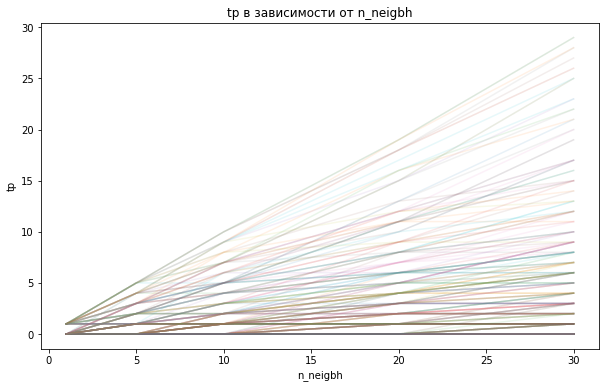

In [37]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["tp"], alpha=0.1)
plt.plot()
plt.title("tp в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("tp")
plt.show()

In [38]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.211009
5     0.186544
10    0.181346
20    0.168349
30    0.161774
Name: accuracy, dtype: float64

In [39]:
# средняя accuracy для каждого количества ближайших соседей
metrics[metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)].groupby("n_neighb")["accuracy"].mean()

n_neighb
1     0.050000
5     0.062222
10    0.059444
20    0.053611
30    0.047778
Name: accuracy, dtype: float64

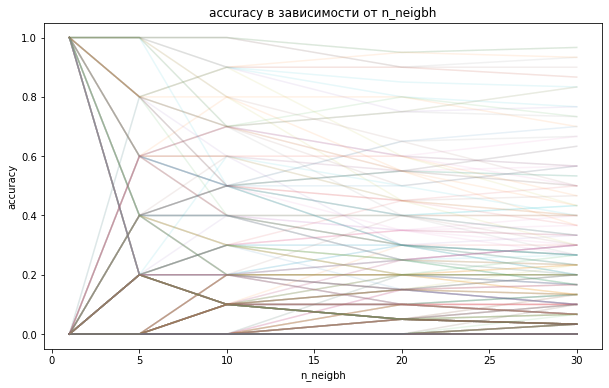

In [40]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["accuracy"], alpha=0.1)
plt.plot()
plt.title("accuracy в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("accuracy")
plt.show()

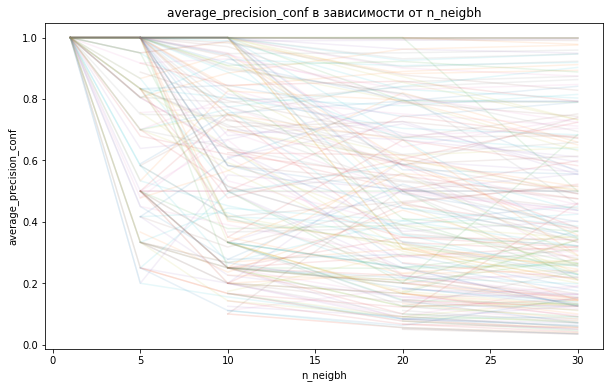

In [41]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_conf"], alpha=0.1)
plt.plot()
plt.title("average_precision_conf в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_conf")
plt.show()

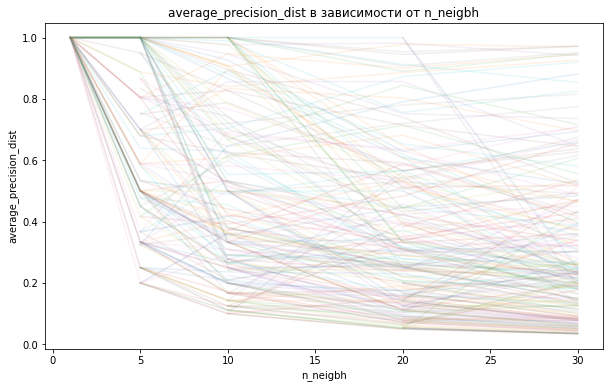

In [42]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_dist"], alpha=0.1)
plt.plot()
plt.title("average_precision_dist в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_dist")
plt.show()

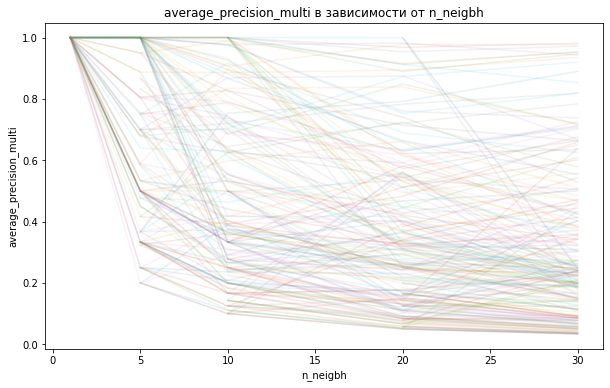

In [43]:
plt.figure(figsize=(10, 6))
for index, row in metrics[metrics["category_id"].isin(ann[ann > 100].index)].groupby("category_id"):
    plt.plot(row["n_neighb"], row["average_precision_multi"], alpha=0.1)
plt.plot()
plt.title("average_precision_multi в зависимости от n_neigbh")
plt.xlabel("n_neigbh")
plt.ylabel("average_precision_multi")
plt.show()

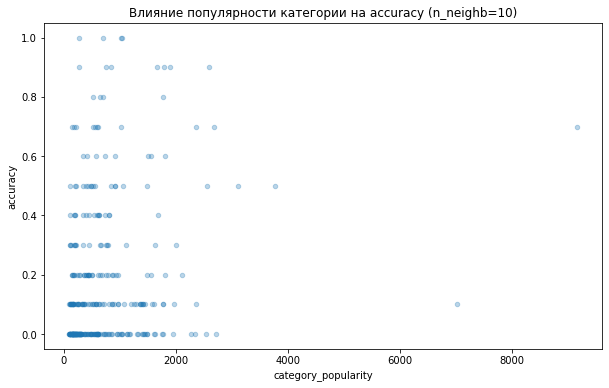

In [44]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на accuracy (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

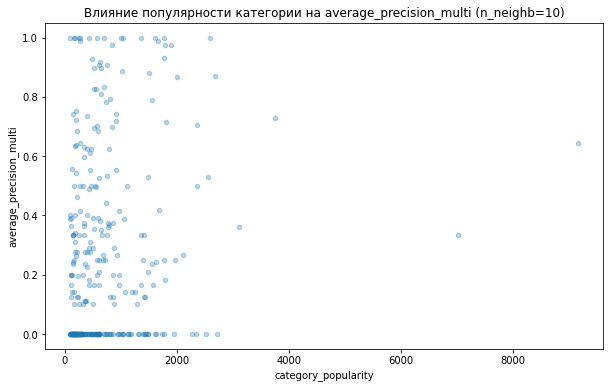

In [45]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

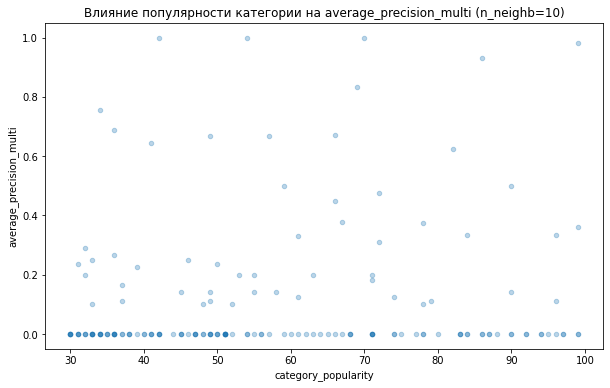

In [46]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[(ann >= 30) & (ann <= 100)].index)]
    .fillna(0)
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .plot(
        "category_popularity",
        "average_precision_multi",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на average_precision_multi (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

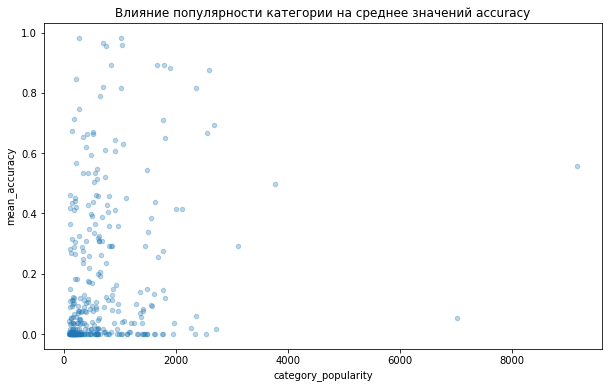

In [47]:
(
    metrics[metrics["category_id"].isin(ann[ann > 100].index)]
    .merge(ann.reset_index(name="category_popularity"), left_on="category_id", right_on="index")
    .groupby(["category_id", "category_popularity"])["accuracy"]
    .mean()
    .reset_index(name="mean_accuracy")
    .plot(
        "category_popularity",
        "mean_accuracy",
        kind="scatter",
        alpha=0.3,
        title="Влияние популярности категории на среднее значений accuracy",
        figsize=(10, 6),
    )
)
plt.show()

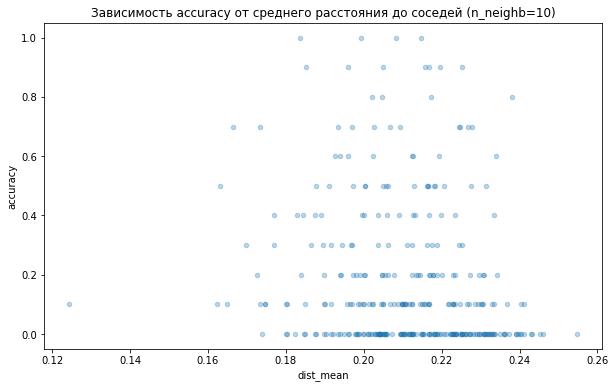

In [48]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "dist_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего расстояния до соседей (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

In [49]:
# top категорий по минимальному расстоянию до соседей (что хорошо знает clip)
metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].sort_values("dist_mean").head(
    10
)

,category_id,category_name,n_neighb,average_precision_conf,average_precision_dist,average_precision_multi,tp,dist_mean,conf_mean,iou_mean,accuracy
5772,1155,wall_socket,10,0.250000,0.250000,0.250000,1,0.124446,0.968441,0.936344,0.1
1302,261,cistern,10,0.166667,0.142857,0.142857,1,0.162423,0.998882,0.961339,0.1
1357,272,clock_tower,10,0.605397,0.647619,0.753333,5,0.163190,0.980173,0.823096,0.5
2567,514,green_bean,10,0.500000,0.166667,0.166667,1,0.164799,0.980287,0.565072,0.1
3827,766,parking_meter,10,0.937925,0.621088,0.632993,7,0.166438,0.992625,0.947562,0.7
1422,285,coffee_table,10,0.680556,0.341667,0.341667,3,0.169763,0.996503,0.825079,0.3
382,77,bed,10,0.277778,0.277778,0.291667,2,0.172477,0.993674,0.551221,0.2
5662,1133,umbrella,10,0.200000,1.000000,1.000000,1,0.173459,0.994131,0.847413,0.1
5092,1019,stop_sign,10,0.909354,0.666327,0.685374,7,0.173476,0.998060,0.954862,0.7
1787,358,deck_chair,10,NaN,NaN,NaN,0,0.173953,0.990594,NaN,0.0


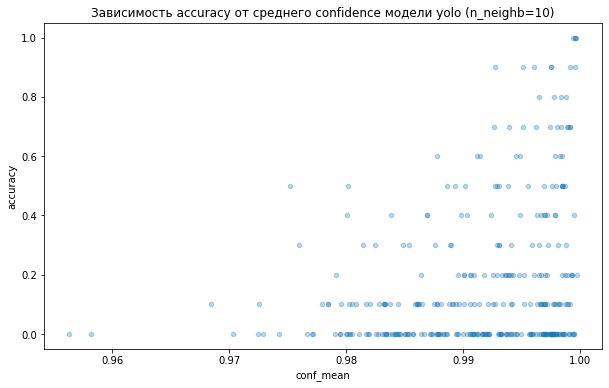

In [50]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

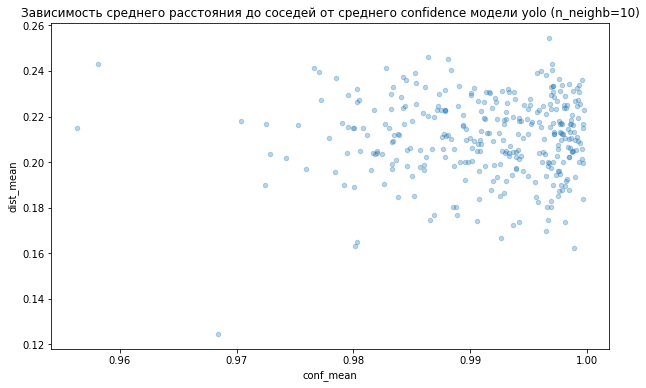

In [51]:
(
    metrics[(metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)].plot(
        "conf_mean",
        "dist_mean",
        kind="scatter",
        alpha=0.3,
        title="Зависимость среднего расстояния до соседей от среднего confidence модели yolo (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()

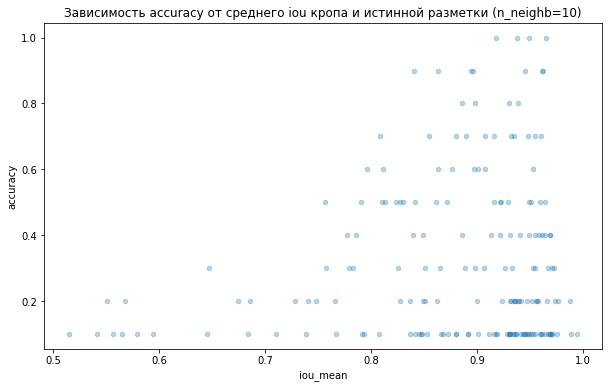

In [52]:
(
    metrics[
        (metrics["tp"] != 0) & (metrics["n_neighb"] == 10) & metrics["category_id"].isin(ann[ann > 100].index)
    ].plot(
        "iou_mean",
        "accuracy",
        kind="scatter",
        alpha=0.3,
        title="Зависимость accuracy от среднего iou кропа и истинной разметки (n_neighb=10)",
        figsize=(10, 6),
    )
)
plt.show()